# Описание проекта

Датасет Taxi содержит данные о подтверждении/отклонении поездок водителями такси, а также данные о каждой поездке.
Датасет включает в себя следующие переменные:

weekday_key - день недели

hour_key - время заказа такси

driver_latitude/driver_longitude - место положение водителя в момент поступления заказа

origin_order_latitude/origin_order_longitude - местоположение клиента в момент заказа такси

distance_km - дальность поездки

duration_min - длительность поездки

offer_class_group - класс автомобиля

ride_type_desc - тип поездки

driver_response - ответ водителя - подтверждение (1)/отказ (0)

Целью данного проекта является построение и оценка моделей машинного обучения для прогнозирования поведения водителя в момент подтверждения/отклонения поступившего заказа на поездку, а также установление факторов, повлиявших на его решение. 

In [13]:
# импортируем модули
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import haversine as hs
from scipy import stats
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score

In [14]:
# импортируем dataset
taxi = pd.read_csv('taxi_new.csv')
taxi.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [15]:
# проверим основные характеристики нашего датасета
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   offer_gk                100000 non-null  int64  
 1   weekday_key             100000 non-null  int64  
 2   hour_key                100000 non-null  int64  
 3   driver_gk               100000 non-null  int64  
 4   order_gk                100000 non-null  int64  
 5   driver_latitude         100000 non-null  float64
 6   driver_longitude        100000 non-null  float64
 7   origin_order_latitude   100000 non-null  float64
 8   origin_order_longitude  100000 non-null  float64
 9   distance_km             100000 non-null  float64
 10  duration_min            100000 non-null  float64
 11  offer_class_group       100000 non-null  object 
 12  ride_type_desc          100000 non-null  object 
 13  driver_response         100000 non-null  int64  
dtypes: float64(6), int64(

In [16]:
# проверим основную статистику по данным
taxi.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.662189e+05,3.159860,13.827790,3446.376360,460867.01291,55.700824,37.492292,55.772440,37.541637,18.393518,23.134841,0.492480
std,3.259360e+05,2.054222,7.306496,2038.738677,266064.98953,2.135903,1.454640,0.665985,0.467758,41.129296,33.890105,0.499946
min,4.000000e+00,0.000000,0.000000,14.000000,18.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2.855552e+05,1.000000,8.000000,1421.000000,229178.50000,55.708651,37.413497,55.708032,37.407117,-1.000000,-1.000000,0.000000
50%,5.656715e+05,3.000000,16.000000,3506.500000,462420.00000,55.772904,37.533664,55.772561,37.532537,10.411500,19.700000,0.000000
75%,8.487198e+05,5.000000,20.000000,5242.000000,690894.00000,55.960667,37.624113,55.962000,37.624358,30.665250,37.867000,1.000000
max,1.130355e+06,6.000000,23.000000,6806.000000,920344.00000,56.174097,38.280547,56.311121,38.243608,5234.283000,3958.283000,1.000000


In [17]:
# выведем количество строк, где 'duration_min' и 'distance_km' меньше нуля
print(len(taxi[taxi['duration_min'] < 0]))
print(len(taxi[taxi['distance_km'] < 0]))

26207
26207


In [18]:
# выведем количество строк, где 'duration_min' и 'distance_km' равны нулю
print(len(taxi[taxi['duration_min'] == 0]))
print(len(taxi[taxi['distance_km'] == 0]))

152
152


Мы имеем 26207 строк, где две переменные distance_km и duration_min имеют значение "-1" и 152 строки, где эти же переменные имеют значение "0". Эти данные мы считаем, как отсутствующие. Объяснить такой объем отсутствующих данных (26%) можно тем, что это заказы, отмененные клиентом до начала поездки. Удалять эти строки нецелесообразно по двум причинам. Во-первых, когда заказ только поступает водителю, там указана продолжительность поездки и расстояние фактическое, отличное от нуля. И водитель узнает об отмене заказа уже после того, как он подтвердит заказ. В противном случае водители такие заказы отклоняли бы в 100% случаев, зная, что заказ не состоится. Вторая причина заключается в том, что некоторые агрегаторы такси до того момента, пока водитель не подтвердит заказ, сообщают ему только расстояние до места посадки клиента, а эту метрику мы рассчитаем на основе latitude и longitude данных. Водитель узнает, куда он повезет клиента только после того, как подтвердит заказ. Агрегаторы делают это для того, чтобы водители не отказывались от коротких и невыгодных заказов т. к. после подтверждения за отказ водитель получит штрафные санкции. В этом случае переменные distance_km и duration_min на результат исследования влиять не будут, а значительными будут другие переменные, по которым у нас есть фактические данные. Мы проверим оба эти предположения в исследовании, а сейчас заменим '-1' и '0' на средние значения по каждой переменной, предварительно проверив распределение пропущенных данных.

In [19]:
# заменим отсутствующие данные на np.nan
taxi['distance_km'].replace([-1, 0], np.nan, inplace=True)
taxi['duration_min'].replace([-1, 0], np.nan, inplace=True)

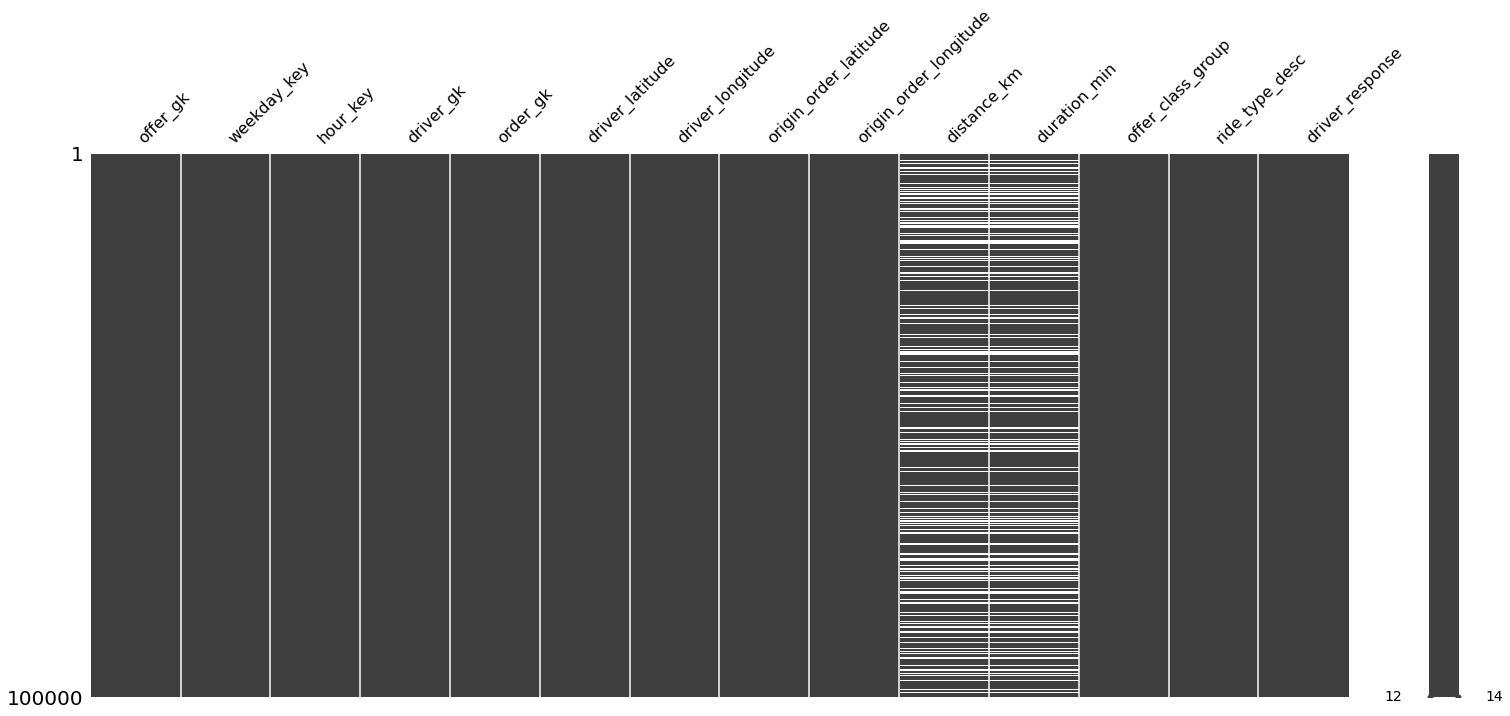

In [21]:
# проверим распределение пропущенных данных
msno.matrix(taxi)
plt.show()

In [22]:
# заменим отсутствующие данные на среднее значение переменной
imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
taxi[['distance_km', 'duration_min']] = imp.fit_transform(taxi[['distance_km', 'duration_min']])

In [23]:
# проверим датасет на наличие повторяющихся строк
duplicates = taxi.duplicated(keep=False)
taxi[duplicates]

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response


# Feature engineering

На основе данных Latitude и Longitude водителя и местоположения клиента рассчитаем расстояние от водителя до клиента в километрах. 

In [76]:
# рассчитаем новую переменную "dist_to_client_km"
for i, row in taxi.iterrows():
    lat1 = taxi['driver_latitude']
    lon1 = taxi['driver_longitude']
    lat2 = taxi['origin_order_latitude']
    lon2 = taxi['origin_order_longitude']
    taxi.loc[i, "dist_to_client_km"] = hs.haversine(
        (lat1[i], lon1[i]), (lat2[i], lon2[i]))

In [77]:
taxi['dist_to_client_km'].head()

0    1.363047
1    3.413097
2    0.410000
3    0.647473
4    1.062483
Name: dist_to_client_km, dtype: float64

In [78]:
# рассчитаем максимальное расстояние до клиента и среднее значение
print(taxi['dist_to_client_km'].max())
print(taxi['dist_to_client_km'].mean())

7276.413211318838
12.071258006437121


In [79]:
# рассчитаем количество поездок, где до места посадки клиента более 200 км и минимальное значение из выборки
print(len(taxi[taxi['dist_to_client_km'] > 200]))
print(taxi['dist_to_client_km'][taxi['dist_to_client_km'] > 200].min())

154
7048.445549243168


Наш датасет содержит 154 поездки, где расстояние до места посадки клиента превышает 7048 км, что является ошибкой. Мы удалим эти строки из исследования.

In [80]:
# удалим строки, где расстояние до клиента более 7000 км
taxi = taxi[taxi['dist_to_client_km'] < 7000]
taxi['dist_to_client_km'].max()

22.293526335674816

In [81]:
taxi.columns

Index(['offer_gk', 'weekday_key', 'hour_key', 'driver_gk', 'order_gk',
       'driver_latitude', 'driver_longitude', 'origin_order_latitude',
       'origin_order_longitude', 'distance_km', 'duration_min',
       'offer_class_group', 'ride_type_desc', 'driver_response',
       'dist_to_client_km'],
      dtype='object')

Переменные 'offer_gk', 'driver_gk', 'order_gk', 'driver_latitude', 'driver_longitude', 'origin_order_latitude' и 'origin_order_longitude'  не содержат полезной информации для исследования, поэтому мы удалим эти данные.

In [11]:
# удалим ненужные переменные
taxi.drop(['offer_gk', 'driver_gk', 'order_gk', 
                       'driver_latitude', 'driver_longitude', 
                       'origin_order_latitude', 'origin_order_longitude'], axis=1, inplace=True)

In [12]:
taxi.columns

Index(['weekday_key', 'hour_key', 'distance_km', 'duration_min',
       'offer_class_group', 'ride_type_desc', 'driver_response'],
      dtype='object')

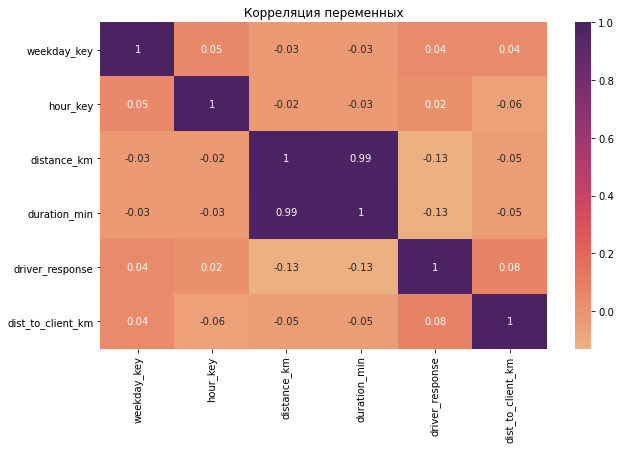

In [84]:
# Проверим корреляцию переменных
plt.figure(figsize = (10, 6))
sns.heatmap(round(taxi.corr(), 2), annot=True, cmap='flare')
plt.title('Корреляция переменных')
plt.show()

Переменные 'distance_km' и 'duration_min' имеют высокую корреляцию и не несут дополнительной информации для анализа. Удалим 'distance_km'.

In [85]:
# удалим 'distance_km'
taxi.drop(['distance_km'], axis=1, inplace=True)

In [86]:
# изолируем целевую переменную
target = ['driver_response']

# изолируем числовые переменные в список
numerical = taxi.dtypes[(taxi.dtypes == 'int64') | (taxi.dtypes == 'float64')
                       ].keys().tolist()
numerical.remove('driver_response')

# сохраним оставшиеся переменные как categorical
categorical = [x for x in taxi.columns if x not in numerical + target ]

# Exploratory data analysis

In [87]:
# проверим целевую переменную на соотношение классов в %
round(taxi.groupby(target).size() / taxi.shape[0]*100, 1)

driver_response
0    50.8
1    49.2
dtype: float64

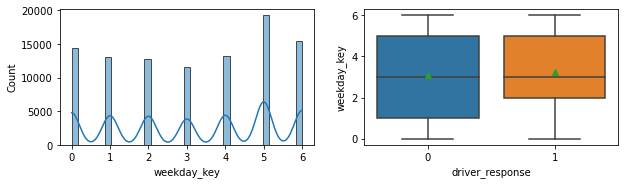

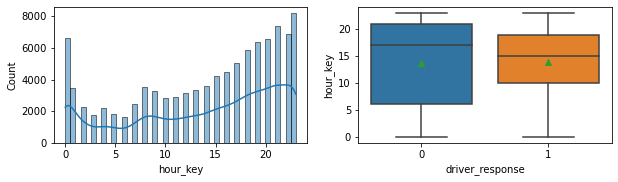

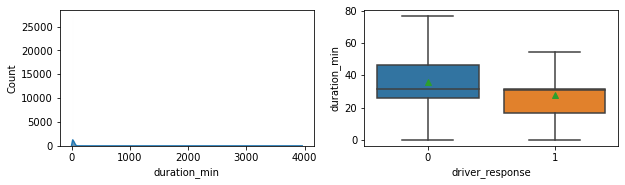

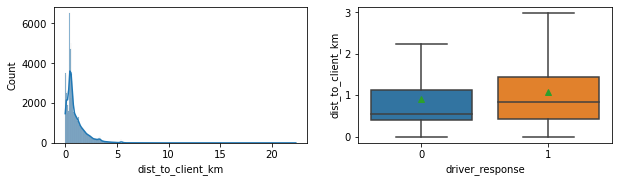

In [88]:
# визуализируем распределение числовых переменных (histogram) и 
# зависимость между ними и целевой переменной (boxplot)
for c in numerical:
    plt.figure(figsize = [10, 2.5])
    plt.subplot(1, 2, 1)
    sns.histplot(x=c, kde=True, data=taxi)
    plt.xlabel(c)
    plt.ylabel('Count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x='driver_response', y=c, data=taxi, showmeans=True, sym="")
    plt.show()

Boxplot демонстрирует четкую зависимость между duration_min и ответом водителя. Так, водители чаще подтверждают заказ, если дальность поездки составляет от 18 до 35 минут и чаще отклоняют заказы, если потенциальная поездка более 35 минут. Также мы видим четкую зависимость между поведением водителя и временем заказа. Водители чаще подтверждают заказы, поступившие между 7 часами утра и 7 часами вечера. Более ранние или более поздние заказы водители чаще отвергают. Причиной этого служит большое количество заказов с 7 вечера до полуночи (histogram). 

Числовые переменные требуют трансформации для ML. 

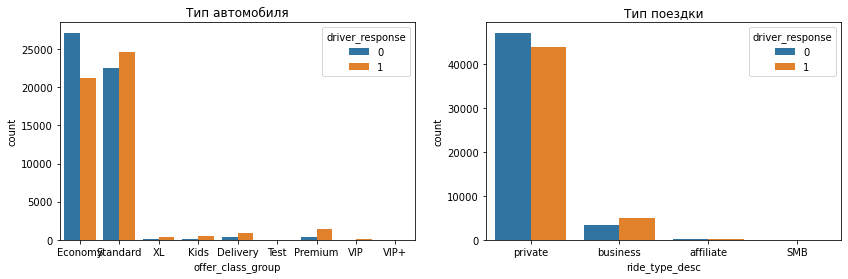

In [89]:
# визуализируем категориальные переменные
fig, axis =plt.subplots(1, 2, figsize = (14, 4))
sns.countplot(x='offer_class_group', data=taxi, hue='driver_response', ax=axis[0])
sns.countplot(x='ride_type_desc', data=taxi, hue='driver_response', ax=axis[1])
axis[0].set_title('Тип автомобиля')
axis[1].set_title('Тип поездки')
plt.show()

При заказе автомобиля эконом класса водители чаще отклоняют поступившие заказы, чем подтверждают. Связано это предположительно с тем, что это самый дешевый вид поездок и на него наибольшее количество заказов (заказов больше, чем водителей). При заказе любых других типов автомобилей водители чаще подтверждают поездки, чем отклоняют. Причиной этого является факт, что эти поездки более дорогие, заказов на них меньше, и водителю они более выгодны. Касательно типа поездок, то в частных поездках водители чаще отказываются от заказов, чем подтверждают их. Основную лепту в это вносят отказы водителей авто в эконом классе (смотри график "Тип автомобиля"). В бизнес-поездках водители чаще подтверждают заказ, чем отклоняют. Связано это с более высокой оплатой таких поездок. 

# Data preprocessing

Улучшим распределение числовых данных, используя логарифмирование и boxcox метод.

array([[<AxesSubplot:title={'center':'weekday_key'}>,
        <AxesSubplot:title={'center':'hour_key'}>],
       [<AxesSubplot:title={'center':'duration_min'}>,
        <AxesSubplot:title={'center':'dist_to_client_km'}>]], dtype=object)

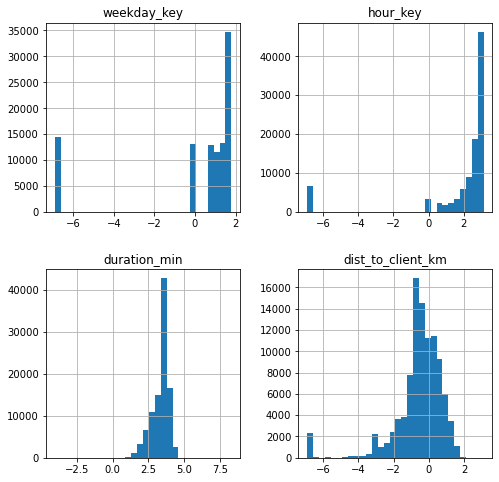

In [90]:
# преобразуем данные, используя np.log() 
taxi_numerical = taxi[numerical]
taxi_numerical = taxi_numerical + 0.001
taxi_numerical_log = np.log(taxi_numerical)
taxi_numerical_log.hist(figsize=(8, 8), bins=30)

In [91]:
# преобразуем данные, используя boxcox метод
taxi[numerical] = taxi[numerical] + 0.001
def boxcox_df(x):
    x_boxcox, _ = stats.boxcox(x)
    return x_boxcox
taxi[numerical] = taxi[numerical].apply(boxcox_df, axis=0)

array([[<AxesSubplot:title={'center':'weekday_key'}>,
        <AxesSubplot:title={'center':'hour_key'}>],
       [<AxesSubplot:title={'center':'duration_min'}>,
        <AxesSubplot:title={'center':'dist_to_client_km'}>]], dtype=object)

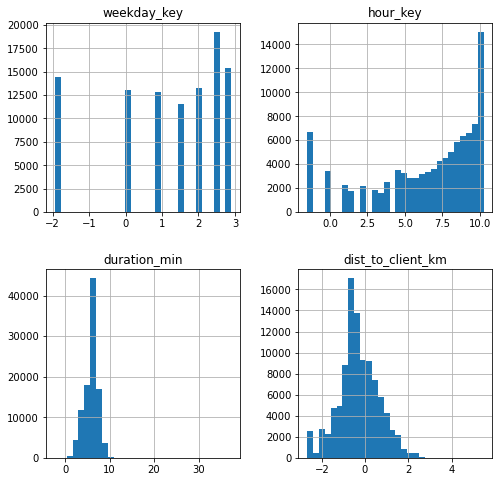

In [92]:
# проверим распределение данных
taxi[numerical].hist(figsize=(8, 8), bins=30)

In [93]:
# преодразуем категориальные переменные 'offer_class_group', 'ride_type_desc' в числовые бинарные данные
taxi = pd.get_dummies(data=taxi, columns=['offer_class_group', 'ride_type_desc'], drop_first=True)

# стандартизируем данные
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(taxi[numerical])

# преобразуем данные в pandas DF
scaled_numerical = pd.DataFrame(scaled_numerical, columns = numerical)

# удалим непреобразованные числовые данные
taxi = taxi.drop(columns = numerical, axis=1)

# соединим DF с преобразованными числовыми данными
taxi.reset_index(drop=True, inplace=True)
taxi_scaled = taxi.merge(right=scaled_numerical, how='left', left_index=True, right_index=True)

In [94]:
# убедимся, что переменные имеют одинаковый mean и std
taxi_scaled[numerical].describe()

,weekday_key,hour_key,duration_min,dist_to_client_km
count,9.984600e+04,9.984600e+04,9.984600e+04,9.984600e+04
mean,1.688605e-15,-2.365598e-16,-1.280918e-14,2.259518e-15
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.985565e+00,-2.294231e+00,-5.295719e+00,-2.559337e+00
25%,-7.549980e-01,-5.964667e-01,-5.721777e-01,-5.184401e-01
50%,1.752139e-01,3.722664e-01,1.924212e-01,-1.064731e-01
75%,8.159240e-01,7.891190e-01,5.280469e-01,6.315897e-01
max,1.087267e+00,1.082727e+00,2.053306e+01,6.226076e+00


In [95]:
# проверим основные характеристики DF с преобразованными данными
taxi_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99846 entries, 0 to 99845
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   driver_response             99846 non-null  int64  
 1   offer_class_group_Economy   99846 non-null  uint8  
 2   offer_class_group_Kids      99846 non-null  uint8  
 3   offer_class_group_Premium   99846 non-null  uint8  
 4   offer_class_group_Standard  99846 non-null  uint8  
 5   offer_class_group_Test      99846 non-null  uint8  
 6   offer_class_group_VIP       99846 non-null  uint8  
 7   offer_class_group_VIP+      99846 non-null  uint8  
 8   offer_class_group_XL        99846 non-null  uint8  
 9   ride_type_desc_affiliate    99846 non-null  uint8  
 10  ride_type_desc_business     99846 non-null  uint8  
 11  ride_type_desc_private      99846 non-null  uint8  
 12  weekday_key                 99846 non-null  float64
 13  hour_key                    998

Наши данные готовы для построения моделей.

# LogisticRegression model

In [96]:
# разделим датасет на независимые переменные (features) и целевую переменную
X = taxi_scaled.drop('driver_response', axis=1)
y = taxi_scaled['driver_response']

# разделим выборку на обучаемую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

# построим LogisticRegression
logreg = LogisticRegression(max_iter = 500)
logreg.fit(X_train, y_train)

# спрогнозируем классы на тестовых данных
y_pred = logreg.predict(X_test)

# рассчитаем метрики
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))

Accuracy:  0.6371770047406022
Precision:  0.6394822006472491
Recall:  0.602970095612667


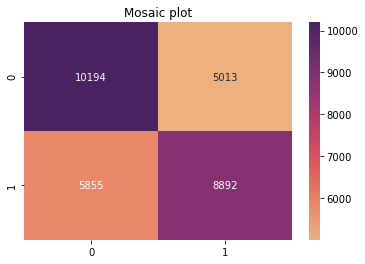

In [97]:
# рассчитаем confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# визуализируем confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='flare')
plt.title('Mosaic plot')
plt.show()

# Model tuning

LogisticRegression по умолчанию использует L2 регуляризацию, которая позволяет оптимизировать overfitting, но не позволяет оценить влияние переменных. 

Подберем С параметр для L1 регуляризации. Это позволит упростить модель, оптимизировав метрики, и оценить значительность переменных.

In [98]:
# создадим список со значениями параметра "C"
C_values = np.linspace(0.01, 4, 10)

# создадим пустой numpy array с нулевыми значениями
l1_metrics = np.zeros((len(C_values), 5))

# добавим значения параметра C в первую колонку
l1_metrics[:, 0] = C_values

# построим logisticRegression с каждым значением С
coef = []
accuracy = []
precision = []
recall = []
for x in C_values:
    logreg_l1 = LogisticRegression(max_iter = 1000, penalty = 'l1', C = x, solver = 'saga')
    logreg_l1.fit(X_train, y_train)
    y_pred = logreg_l1.predict(X_test)
    coef.append(np.count_nonzero(logreg_l1.coef_))
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
l1_metrics[:, 1] = coef
l1_metrics[:, 2] = accuracy
l1_metrics[:, 3] = precision
l1_metrics[:, 4] = recall

# создадим pandas DF со значениями С и основными метриками
col_names = ['C', 'Non_zero_coef', 'Accuracy', 'Precision', 'Recall']
pd.DataFrame(l1_metrics, columns = col_names)

,C,Non_zero_coef,Accuracy,Precision,Recall
0,0.010000,8.0,0.638913,0.638954,0.612870
1,0.453333,14.0,0.637244,0.639414,0.603513
2,0.896667,14.0,0.637210,0.639488,0.603106
3,1.340000,14.0,0.637177,0.639482,0.602970
4,1.783333,14.0,0.637144,0.639456,0.602902
5,2.226667,14.0,0.637110,0.639430,0.602834
6,2.670000,15.0,0.637177,0.639502,0.602902
7,3.113333,14.0,0.637177,0.639502,0.602902
8,3.556667,14.0,0.637177,0.639502,0.602902
9,4.000000,14.0,0.637177,0.639502,0.602902


In [155]:
# построим LogisticRegression с параметром С = 0.01
logreg_tuned = LogisticRegression(max_iter = 1000, penalty = 'l1', C = 0.01, solver = 'saga')
logreg_tuned.fit(X_train, y_train)
y_pred_log = logreg_tuned.predict(X_test)

# рассчитаем метрики
accuracy_log = accuracy_score(y_test, y_pred_log)
precision_log = precision_score(y_test, y_pred_log)
recall_log =  recall_score(y_test, y_pred_log)
print('Accuracy: ', accuracy_log)
print('Precision: ', precision_log)
print('Recall: ', recall_log)

Accuracy:  0.6389129999332309
Precision:  0.638953693884765
Recall:  0.612870414321557


При "С" = 0.01 мы упростили модель, снизив количество переменных до восьми. При этом мы улучшили Accuracy с 0.6371 до 0.6389, Recall с 0.6029 до 0.6128. Precision снизился с 0.6394 до 0.6389. 

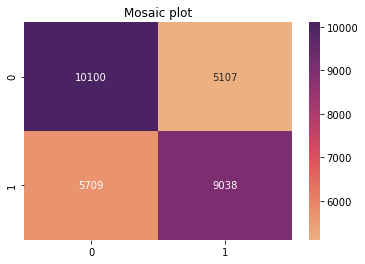

In [100]:
# создадим confusion matrix
conf_matrix_tuned = confusion_matrix(y_test, y_pred_log)

# визуализируем confusion matrix
sns.heatmap(conf_matrix_tuned, annot=True, fmt='.0f', cmap='flare')
plt.title('Mosaic plot')
plt.show()

Mosaic plot показывает, что модель работает практически одинаково на оба класса.

# LogisticRegression, оценка значительности переменных

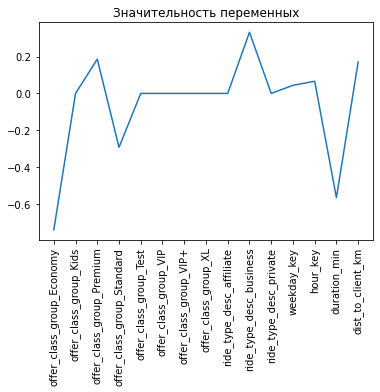

In [101]:
# визуализируем значительность переменных
coeff_chart = pd.DataFrame(X.columns, columns = ['features'])
coeff_chart['coef'] = np.transpose(logreg_tuned.coef_)
plt.plot(coeff_chart['features'], coeff_chart['coef'])
plt.xticks(rotation=90)
plt.title('Значительность переменных')
plt.show()

In [102]:
# коэффиценты модели в табличном виде
coeff_chart['Exp_coefficient'] = np.exp(coeff_chart['coef'])
coeff_chart = coeff_chart[coeff_chart['coef'] !=0]
coeff_chart.sort_values(by=['Exp_coefficient'])

,features,coef,Exp_coefficient
0,offer_class_group_Economy,-0.739657,0.477277
13,duration_min,-0.564886,0.568425
3,offer_class_group_Standard,-0.291788,0.746927
11,weekday_key,0.043877,1.044854
12,hour_key,0.065951,1.068175
14,dist_to_client_km,0.170368,1.185741
2,offer_class_group_Premium,0.185967,1.204383
9,ride_type_desc_business,0.331553,1.393130


Переменные "offer_class_group_Economy" и "duration_min" имеют наибольшее влияние на поведение водителей. При увеличении этих параметров водители чаще отказываются от заказа.

# DecisionTreeClassifier

In [103]:
# построим DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X_train, y_train)

# спрогнозируем классы на обучающих и тестовых данных
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)

# рассчитаем метрики
print('Accuracy train: ', accuracy_score(y_train, y_pred_train))
print('Accuracy test: ', accuracy_score(y_test, y_pred_test))
print('Precision train: ', precision_score(y_train, y_pred_train))
print('Precision test: ', precision_score(y_test, y_pred_test))
print('Recall train: ', recall_score(y_train, y_pred_train))
print('Recall test: ', recall_score(y_test, y_pred_test))

Accuracy train:  0.9960510501917244
Accuracy test:  0.6483608199238833
Precision train:  0.9997946672142207
Precision test:  0.645230217810863
Recall train:  0.9921695339562775
Recall test:  0.6347731742049231


Метрики показывают, что модель хорошо запоминает взаимосвязи на обучающих данных, но работает значительно хуже на тестовых данных. Нам необходимо уменьшить размер дерева или лимитировать количество if-else правил, скорректировав max_depth параметр.

In [104]:
# создадим список со значениями параметра max_depth
depth_list = np.arange(2, 15)
depth_tuning = np.zeros((len(depth_list), 4))
depth_tuning[:, 0] = depth_list

# построим DecisionTreeClassifier с каждым значением max_depth
accuracy = []
precision = []
recall = []
for x in depth_list:
    tree_depth = DecisionTreeClassifier(max_depth = x)
    tree_depth.fit(X_train, y_train)
    y_pred = tree_depth.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
depth_tuning[:, 1] = accuracy
depth_tuning[:, 2] = precision
depth_tuning[:, 3] = recall
col_names = ['Max_depth', 'Accuracy', 'Precision', 'Recall']
pd.DataFrame(depth_tuning, columns = col_names)

,Max_depth,Accuracy,Precision,Recall
0,2.0,0.637578,0.603095,0.771750
1,3.0,0.643186,0.591945,0.886011
2,4.0,0.667824,0.644671,0.724758
3,5.0,0.680243,0.654955,0.740761
4,6.0,0.686219,0.662257,0.740083
5,7.0,0.691327,0.660707,0.766800
6,8.0,0.692495,0.659723,0.775276
7,9.0,0.695633,0.661263,0.782735
8,10.0,0.697269,0.668968,0.762325
9,11.0,0.696301,0.670922,0.751950


При величине  параметра max_depth = 9 мы улучшаем все три метрики Accuracy с 0.6475 до 0.6957, Precision с 0.6447 до 0.6613 и Recall с 0.6327 до 0.7828

In [156]:
# построим DecisionTreeClassifier c параметром max_depth = 9
tree_tuned = DecisionTreeClassifier(max_depth = 9, random_state=1)
tree_tuned.fit(X_train, y_train)

# спрогнозируем классы на обучающих и тестовых данных
y_pred_train_tree = tree_tuned.predict(X_train)
y_pred_test_tree = tree_tuned.predict(X_test)

# рассчитаем метрики
accuracy_train_tree = accuracy_score(y_train, y_pred_train_tree)
accuracy_test_tree = accuracy_score(y_test, y_pred_test_tree)
precision_train_tree = precision_score(y_train, y_pred_train_tree)
precision_test_tree = precision_score(y_test, y_pred_test_tree)
recall_train_tree = recall_score(y_train, y_pred_train_tree)
recall_test_tree = recall_score(y_test, y_pred_test_tree)

print('Accuracy train: ', accuracy_train_tree)
print('Accuracy test: ', accuracy_test_tree)
print('Precision train: ', precision_train_tree)
print('Precision test: ', precision_test_tree)
print('Recall train: ', recall_train_tree)
print('Recall test: ', recall_test_tree)

Accuracy train:  0.7089938762662393
Accuracy test:  0.695800227014756
Precision train:  0.672060701306355
Precision test:  0.6613411212277387
Recall train:  0.7966989782551742
Recall test:  0.7831423340340409


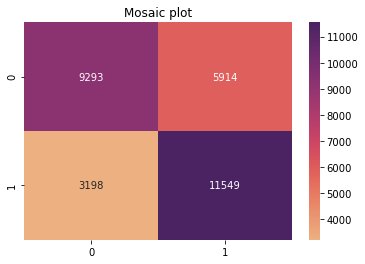

In [106]:
# создадим confusion matrix
conf_matrix_tree = confusion_matrix(y_test, y_pred_test_tree)

# визуализируем confusion matrix
sns.heatmap(conf_matrix_tree, annot=True, fmt='.0f', cmap='flare')
plt.title('Mosaic plot')
plt.show()

# DecisionTreeClassifier, интерпретация модели

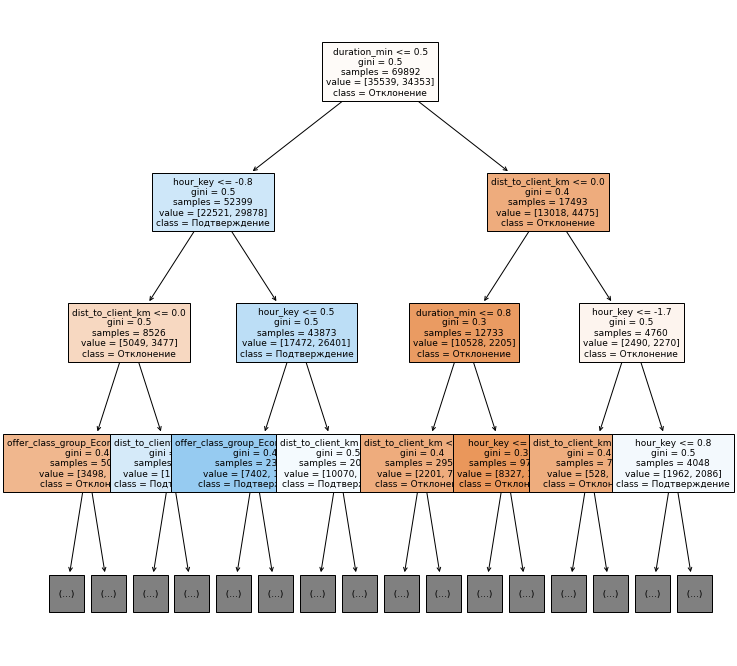

In [114]:
# визуализируем модель
plt.figure(figsize=(12, 12))
tree.plot_tree(tree_tuned, max_depth=3,
              feature_names=X_train.columns, filled=True, 
              class_names=['Отклонение', 'Подтверждение'],
              precision=1, fontsize=9)
plt.show()

Диаграмма показывает, что переменная 'duration_min' оказывает наибольшее влияние на выбор водителя отклонить или принять заказ. Мы видим, что если 'duration_min' <= 0.5 и 'hour_key' > -0.8, водитель обычно подтверждает заказ.

# RandomForestClassifier

In [157]:
# построим RandomForestClassifier 
forest = RandomForestClassifier(random_state=1).fit(X_train, y_train)

# спрогнозируем классы на обучающих и тестовых данных
y_pred_train_forest = forest.predict(X_train)
y_pred_test_forest = forest.predict(X_test)

# рассчитаем метрики
accuracy_train_forest = accuracy_score(y_train, y_pred_train_forest)
accuracy_test_forest = accuracy_score(y_test, y_pred_test_forest)
precision_train_forest = precision_score(y_train, y_pred_train_forest)
precision_test_forest = precision_score(y_test, y_pred_test_forest)
recall_train_forest = recall_score(y_train, y_pred_train_forest)
recall_test_forest = recall_score(y_test, y_pred_test_forest)

print('Accuracy train: ', accuracy_train_forest)
print('Accuracy test: ', accuracy_test_forest)
print('Precision train: ', precision_train_forest)
print('Precision test: ', precision_test_forest)
print('Recall train: ', recall_train_forest)
print('Recall test: ', recall_test_forest)

Accuracy train:  0.9960367424025639
Accuracy test:  0.6931962342258129
Precision train:  0.9975760761637755
Precision test:  0.6854930235663262
Recall train:  0.9943527493959771
Recall test:  0.6962772089238489


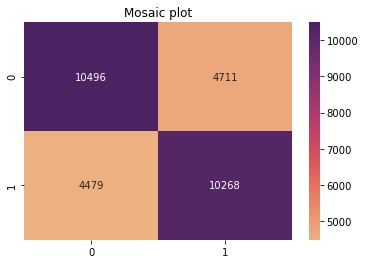

In [129]:
# создадим confusion matrix
conf_matrix_forest = confusion_matrix(y_test, y_pred_test_forest)

# визуализируем confusion matrix
sns.heatmap(conf_matrix_forest, annot=True, fmt='.0f', cmap='flare')
plt.title('Mosaic plot')
plt.show()

# Model tuning

In [122]:
# оптимизируем параметры модели
param_dist = {'n_estimators':np.arange(10, 51),
             'max_depth':[3, None],
             'max_features':['auto', 'sqrt', 'log2'],
             'bootstrap':[True, False], 
             'criterion': ['gini', 'entropy']}
random_search = RandomizedSearchCV(forest, param_dist, random_state=111)
random_search.fit(X_train, y_train)
y_pred_train_forest = random_search.predict(X_train)
y_pred_test_forest = random_search.predict(X_test)
print(random_search.best_params_)

{'n_estimators': 49, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


In [127]:
# построим RandomForestClassifier с расчетными параметрами
forest_tuned = RandomForestClassifier(n_estimators=49, max_features='auto', 
                                max_depth=None, criterion='gini', 
                                bootstrap=False, random_state=87).fit(X_train, y_train)

# спрогнозируем классы на обучающих и тестовых данных
y_pred_train_f_tuned = forest_tuned.predict(X_train)
y_pred_test_f_tuned = forest_tuned.predict(X_test)

# расчитаем метрики
print('Accuracy train: ', accuracy_score(y_train, y_pred_train_f_tuned))
print('Accuracy test: ', accuracy_score(y_test, y_pred_test_f_tuned))
print('Precision train: ', precision_score(y_train, y_pred_train_f_tuned))
print('Precision test: ', precision_score(y_test, y_pred_test_f_tuned))
print('Recall train: ', recall_score(y_train, y_pred_train_f_tuned))
print('Recall test: ', recall_score(y_test, y_pred_test_f_tuned))

Accuracy train:  0.9960510501917244
Accuracy test:  0.6811110369232823
Precision train:  0.9997946672142207
Precision test:  0.6752344329757809
Recall train:  0.9921695339562775
Recall test:  0.6787143147758866


Наша первоначальная модель показала лучший результат по всем метрикам. 

# RandomForestClassifier, оценка значительности переменных

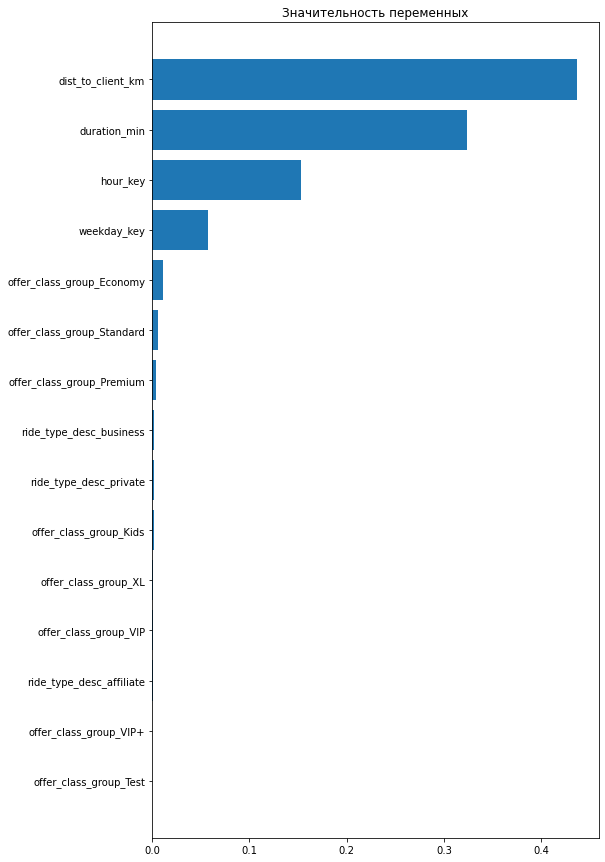

In [151]:
# визуализируем значительность переменных
importances = forest.feature_importances_
sorted_index = np.argsort(importances)
labels = X.columns[sorted_index]
plt.figure(figsize=(8, 15))
plt.barh(range(X.shape[1]), importances[sorted_index], tick_label=labels)
plt.title('Значительность переменных')
plt.show()

RandomForestClassifier показывает, что наиболее значимыми являются переменные: 'dist_to_client_km', 'duration_min' и 'hour_key'.

# Выбор модели

Для сравнения моделей мы построим ROC curve и Precision-Recall curve, а также рассчитаем area under the curve(AUC), average precision(AP) и F1 score. После этого мы выберем модель, которая демонстрирует наилучший результат.

In [154]:
# рассчитаем f1 score
f1_logreg = f1_score(y_test, y_pred_log)
f1_tree = f1_score(y_test, y_pred_test_tree)
f1_forest = f1_score(y_test, y_pred_test_forest)

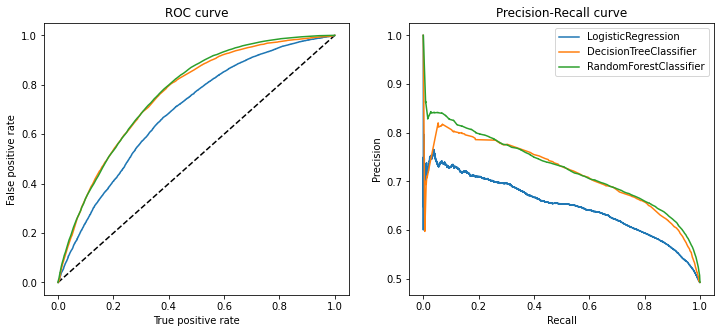

In [153]:
# рассчитаем predicted probabilities
y_pred_prob_logreg_tuned = logreg_tuned.predict_proba(X_test)[:, 1]
y_pred_prob_tree_tuned = tree_tuned.predict_proba(X_test)[:, 1]
y_pred_prob_forest = forest.predict_proba(X_test)[:, 1]

# рассчитаем area under the curve AUC
auc_logreg = roc_auc_score(y_test, y_pred_prob_logreg_tuned)
auc_tree = roc_auc_score(y_test, y_pred_prob_tree_tuned)
auc_forest = roc_auc_score(y_test, y_pred_prob_forest)

# рассчитаем avearge precision AP
ap_logreg = average_precision_score(y_test, y_pred_prob_logreg_tuned)
ap_tree = average_precision_score(y_test, y_pred_prob_tree_tuned)
ap_forest = average_precision_score(y_test, y_pred_prob_forest)

# рассчитаем метрики для ROC curve
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(
    y_test, y_pred_prob_logreg_tuned)
fpr_tree, tpr_tree, thresholds_tree = roc_curve(
    y_test, y_pred_prob_tree_tuned)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(
    y_test, y_pred_prob_forest)

# рассчитаем метрики для precision-recall curve
precision_logreg, recall_logreg, thresholds_logreg = precision_recall_curve(
    y_test, y_pred_prob_logreg_tuned)
precision_tree, recall_tree, thresholds_tree = precision_recall_curve(
    y_test, y_pred_prob_tree_tuned)
precision_forest, recall_forest, thresholds_forest = precision_recall_curve(
    y_test, y_pred_prob_forest)

# визуализируем ROC curve и Precision-Recall curve
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_logreg, tpr_logreg, label='LogisticRegression')
ax[0].plot(fpr_tree, tpr_tree, label='DecisionTreeClassifier')
ax[0].plot(fpr_forest, tpr_forest, label='RandomForestClassifier')
ax[1].plot(recall_logreg, precision_logreg, label='LogisticRegression')
ax[1].plot(recall_tree, precision_tree, label='DecisionTreeClassifier')
ax[1].plot(recall_forest, precision_forest, label='RandomForestClassifier')
ax[0].set_xlabel('True positive rate')
ax[0].set_ylabel('False positive rate')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[0].set_title('ROC curve')
ax[1].set_title('Precision-Recall curve')
plt.legend()
plt.show()

In [158]:
# соединим все метрики в pandas DF
all_metrics = pd.DataFrame(
    np.array([[auc_logreg, ap_logreg, f1_logreg, accuracy_log, precision_log, recall_log], 
             [auc_tree, ap_tree, f1_tree, accuracy_test_tree, precision_test_tree, recall_test_tree], 
             [auc_forest, ap_forest, f1_forest, accuracy_test_forest, precision_test_forest, recall_test_forest]]), 
columns = ['AUC', 'Average precision', 'F1 score', 'Accuracy', 'Precision', 'Recall'], 
index = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier'], 
dtype=np.float64)

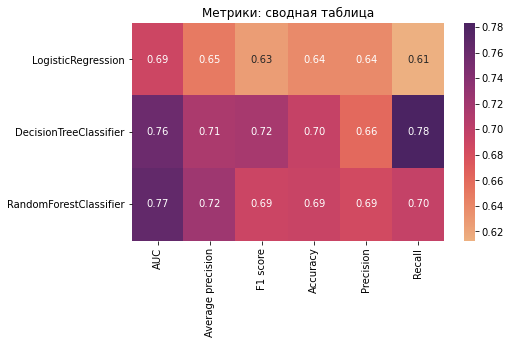

In [159]:
# визуализируем метрики по трем моделям
plt.figure(figsize=(7, 4))
sns.heatmap(data=all_metrics, annot=True, cmap='flare', fmt='.2f')
plt.title('Метрики: сводная таблица')
plt.show()

DecisionTreeClassifier демонстрирует лучший результат практически по всем метрикам. Кроме того, эта модель показывает, что 'duration_min' или длительность поездки - наиболее значимая переменная. Это подтверждает Exploratory data analysis? где прослеживается четкая зависимость между длительностью поездки и поведением водителя. Вторая по значимости переменная - 'hour_key' или время поездки. Это также подтверждается предварительным анализом переменных. По совокупности факторов DecisionTreeClassifier является наилучшей моделью для решения этой задачи.

Наше предварительное предположение, что время поездки или 'duration_min' не является значимым фактором, не подтвердилось. Более того, эта переменная является ключевой при принятии водителем решения о подтверждении поездки. Также мы предполагали, что расстояние до места посадки клиента будет ключевым фактором, что подтвердилось только отчасти. Этот фактор является важным, но не ключевым.